# <font color = 'indianred'>**Sentence pair Classification** </font>


## Outline
1. **Setting up the Environment**: Installing necessary libraries and setting up paths.
2. **Creating Huggingface Dataset for Custom Dataset**: Understanding the structure and content of the dataset.

3. **Data Preprocessing**: Techniques to prepare the data for training, including handling different data splits and tokenization
4. **Training the Model**: Feeding data and adjusting weights.
5. **Inference**: Evaluate model on test set and making predictions.



# <font color = 'indianred'> **Setting up the Environment** </font>



In [85]:
 # CHANGE FOLDERS AS PER YOUR SETUP
from pathlib import Path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    !pip install datasets transformers evaluate wandb accelerate -U -qq
    base_folder = Path("/content/drive/MyDrive/data")
else:
    base_folder = Path("/home/harpreet/Insync/google_drive_shaannoor/data")


from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoTokenizer, DataCollatorWithPadding, Pipeline
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
import evaluate

import torch
from torch.utils.data import DataLoader

import wandb

import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random

import textwrap

In [2]:
# CHANGE FOLDERS TO WHERE YOU WANT TO SAVE DATA AND MODELS
data_folder = base_folder/'datasets/Classification_HW/csv_files'

In [3]:
def print_wrap(text, d):
    # Wrap the text to limit the width to 'd'
    wrapped_text = textwrap.fill(text, width=d)

    # Print the wrapped text
    print(wrapped_text)

# <font color = 'indianred'> **Exploring and Understanding Dataset**

## <font color = 'indianred'> **Recognizing Textual Entailment**</font>



## <font color = 'indianred'> **Load Data set**
    


In [4]:
raw_datasets = load_dataset('glue', 'rte') # Recognizing Textual Entailment

## <font color = 'indianred'> **Understanding your data**

In [5]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 2490
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 277
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3000
    })
})

## <font color = 'indianred'> **Understanding the datatype of columns**


In [6]:
raw_datasets['train'].features


{'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'label': ClassLabel(names=['entailment', 'not_entailment'], id=None),
 'idx': Value(dtype='int32', id=None)}

## <font color = 'indianred'> **Acess indivdual element** </font>


In [7]:
# get the first example of the dataset
raw_datasets['train'][1]


{'sentence1': 'A place of sorrow, after Pope John Paul II died, became a place of celebration, as Roman Catholic faithful gathered in downtown Chicago to mark the installation of new Pope Benedict XVI.',
 'sentence2': 'Pope Benedict XVI is the new leader of the Roman Catholic Church.',
 'label': 0,
 'idx': 1}

In [8]:
print_wrap(raw_datasets['train']['sentence1'][1], 80)

A place of sorrow, after Pope John Paul II died, became a place of celebration,
as Roman Catholic faithful gathered in downtown Chicago to mark the installation
of new Pope Benedict XVI.


In [9]:
print_wrap(raw_datasets['train']['sentence2'][1], 80)

Pope Benedict XVI is the new leader of the Roman Catholic Church.


In [10]:
# get label of last ten examples
raw_datasets['train']['label'][-10:]

[0, 0, 0, 0, 1, 1, 0, 1, 0, 1]

In [12]:
raw_datasets['test']['label'][-10:]

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

In [13]:
raw_datasets['test'][0]

{'sentence1': "Mangla was summoned after Madhumita's sister Nidhi Shukla, who was the first witness in the case.",
 'sentence2': 'Shukla is related to Mangla.',
 'label': -1,
 'idx': 0}

## <font color = 'indianred'> **Exploratory Data Analysis (EDA)**

### <font color = 'indianred'> **Change dataset format to Pandas**  </font>


In [14]:
# Set the format to Pandas
raw_datasets.set_format(type='pandas') # CODE HERE

In [15]:
# get all rows the dataset
df = raw_datasets['train'][:]


In [16]:
df.head()

,sentence1,sentence2,label,idx
0,No Weapons of Mass Destruction Found in Iraq Yet.,Weapons of Mass Destruction Found in Iraq.,1,0
1,"A place of sorrow, after Pope John Paul II die...",Pope Benedict XVI is the new leader of the Rom...,0,1
2,Herceptin was already approved to treat the si...,Herceptin can be used to treat breast cancer.,0,2
3,"Judie Vivian, chief executive at ProMedica, a ...",The previous name of Ho Chi Minh City was Saigon.,0,3
4,A man is due in court later charged with the m...,Paul Stewart Hutchinson is accused of having s...,1,4


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2490 entries, 0 to 2489
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence1  2490 non-null   object
 1   sentence2  2490 non-null   object
 2   label      2490 non-null   int64 
 3   idx        2490 non-null   int32 
dtypes: int32(1), int64(1), object(2)
memory usage: 68.2+ KB


### <font color = 'indianred'> **Visualize distribution of class labels** </font>
It is important to undetrstand the distribution of the class labels to check if there is any imbalance among the categories.

<Axes: ylabel='label'>

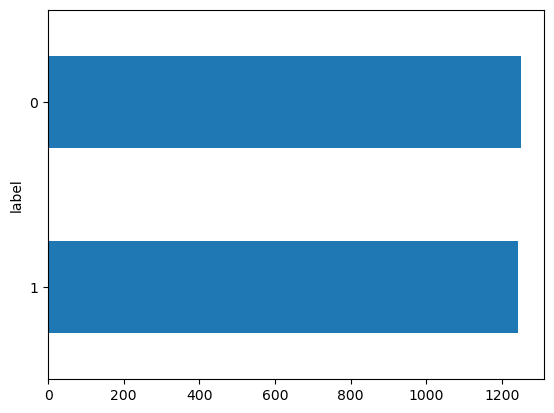

In [18]:
# check distribution of class labels in the dataset
df['label'].value_counts(ascending=True).plot.barh() # CODE HERE

**Conclusions:**



### <font color = 'indianred'> **Check length of the reviews** </font>


In [19]:
# Calculate words per review
df['words_per_review_s1'] = df['sentence1'].str.split().apply(len) 
df['words_per_review_s2'] = df['sentence2'].str.split().apply(len) 


In [20]:
df.head()

,sentence1,sentence2,label,idx,words_per_review_s1,words_per_review_s2
0,No Weapons of Mass Destruction Found in Iraq Yet.,Weapons of Mass Destruction Found in Iraq.,1,0,9,7
1,"A place of sorrow, after Pope John Paul II die...",Pope Benedict XVI is the new leader of the Rom...,0,1,32,12
2,Herceptin was already approved to treat the si...,Herceptin can be used to treat breast cancer.,0,2,33,8
3,"Judie Vivian, chief executive at ProMedica, a ...",The previous name of Ho Chi Minh City was Saigon.,0,3,35,10
4,A man is due in court later charged with the m...,Paul Stewart Hutchinson is accused of having s...,1,4,76,10


#### <font color = 'indianred'> **Plot the distribution of review length** </font>

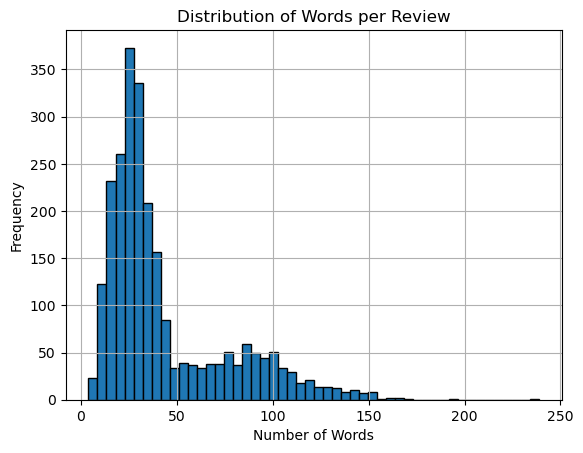

In [21]:
# Plot a histogram of the 'words_per_review' column
df['words_per_review_s1'].hist(bins=50, edgecolor='black')

# Adding labels and a title for clarity
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Words per Review')

# Display the plot
plt.show()


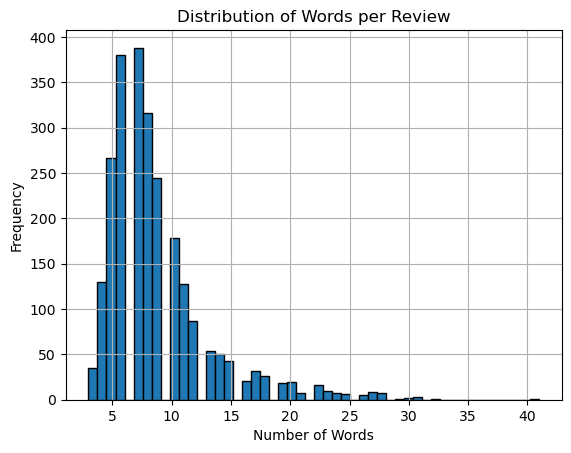

In [22]:
# Plot a histogram of the 'words_per_review' column
df['words_per_review_s2'].hist(bins=50, edgecolor='black')

# Adding labels and a title for clarity
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Words per Review')

# Display the plot
plt.show()

<Axes: title={'center': 'words_per_review_s1'}, xlabel='label'>

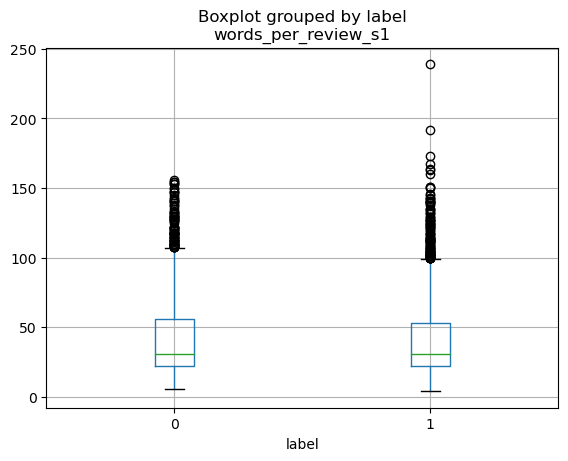

In [23]:
# distribution of number of words for each class label
df.boxplot('words_per_review_s1', by='label')


<Axes: title={'center': 'words_per_review_s2'}, xlabel='label'>

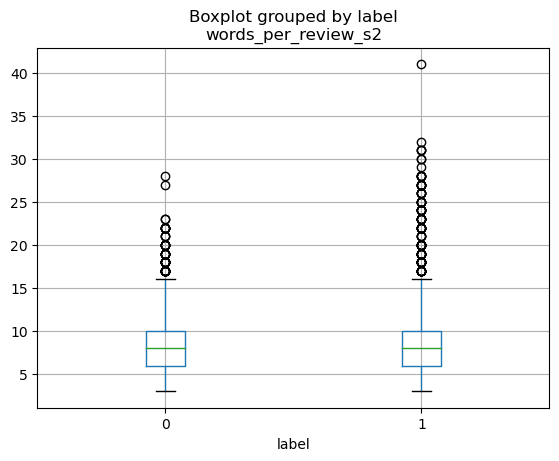

In [24]:
# distribution of number of words for each class label
df.boxplot('words_per_review_s2', by='label')

- From the above graph, it seems that the distribution of number of words is similar for all the classes.
- Most models have max sequence length of 512. None of the observations that have more than 512 words.

### <font color = 'indianred'> **Reset dataset format** </font>


In [25]:
# reset teh format back to huggingface dataset
raw_datasets.reset_format() 


In [26]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 2490
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 277
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3000
    })
})

In [27]:
raw_datasets['train'].features

{'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'label': ClassLabel(names=['entailment', 'not_entailment'], id=None),
 'idx': Value(dtype='int32', id=None)}

# <font color = 'indianred'> **Data Pre-processing**</font>

No pre-processing required for this dataset

## <font color = 'indianred'> **Tokenization**</font>



In [28]:
# Define a checkpoint for the DistilBERT model with an uncased vocabulary.
# Instantiate the tokenizer for this model using the specified checkpoint.
checkpoint = 'google/electra-base-discriminator'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

###  <font color = 'indianred'> **Understanding pre-trained Tokenizer**
We will now understand how the tokenizer work by feeding one simple example.

In [29]:
# get the vocab size
print(f'Pretrained tokenizer vocab size {tokenizer.vocab_size}')

Pretrained tokenizer vocab size 30522


In [30]:
raw_datasets['train'][0]

{'sentence1': 'No Weapons of Mass Destruction Found in Iraq Yet.',
 'sentence2': 'Weapons of Mass Destruction Found in Iraq.',
 'label': 1,
 'idx': 0}

In [31]:
encoded_text = tokenizer(raw_datasets['train']['sentence1'][0],
         raw_datasets['train']['sentence2'][0],padding=True, truncation=True, return_tensors='pt')

In [32]:
encoded_text

{'input_ids': tensor([[ 101, 2053, 4255, 1997, 3742, 6215, 2179, 1999, 5712, 2664, 1012,  102,
         4255, 1997, 3742, 6215, 2179, 1999, 5712, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [33]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids[0])

print(tokens)

['[CLS]', 'no', 'weapons', 'of', 'mass', 'destruction', 'found', 'in', 'iraq', 'yet', '.', '[SEP]', 'weapons', 'of', 'mass', 'destruction', 'found', 'in', 'iraq', '.', '[SEP]']


In [34]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] no weapons of mass destruction found in iraq yet. [SEP] weapons of mass destruction found in iraq. [SEP]'

In [35]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] no weapons of mass destruction found in iraq yet. [SEP] weapons of mass destruction found in iraq. [SEP]'

In [36]:
special_tokens = tokenizer.all_special_tokens
special_tokens_ids = tokenizer.all_special_ids
print(special_tokens, special_tokens_ids)

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'] [100, 102, 0, 101, 103]


###  <font color = 'indianred'> **Create function for Tokenizer**

In [37]:
# Define a function to tokenize the text in a batch using the predefined tokenizer.
# The text data is extracted from the "text" key of the batch.
# The function will truncate the tokenized data if it exceeds the tokenizer's maximum length.

def tokenize_fn(batch):
    return tokenizer(batch['sentence1'], batch['sentence2'], truncation = True)


###  <font color = 'indianred'> **Use map function to apply tokenization to all splits**

In [38]:
# Map the tokenize_fn function over the entire train_val_subset dataset in batches.
# This will tokenize the text data in each batch and return a new dataset with tokenized data.
tokenized_dataset = raw_datasets.map(tokenize_fn, batched=True) 


In [39]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2490
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 277
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
})

We can see that tokenization step has added three new columns ('input_ids', 'token_type_ids', 'attention_mask') to the dataset

In [40]:
tokenized_dataset = tokenized_dataset.remove_columns(
    ['sentence1', 'sentence2', 'idx']
)

In [41]:
tokenized_dataset.set_format(type='torch')

In [42]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2490
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 277
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
})

In [43]:
tokenized_dataset['train'].features

{'label': ClassLabel(names=['entailment', 'not_entailment'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [44]:
print(len(tokenized_dataset["train"]["input_ids"][2]))
print(len(tokenized_dataset["train"]["input_ids"][1]))

59
52


The varying lengths in the dataset indicate that padding has not been applied yet. Instead of padding the entire dataset, we prefer processing small batches during training. Padding is done selectively for each batch based on the maximum length in the batch. We will discuss this in more detail in a later section of this notebook.

#  <font color = 'indianred'> **Model Training**

##  <font color = 'indianred'> **Download pre-trained model**

In [45]:
# Instantiate a model for sequence classification using the specified checkpoint.
# The provided configuration (config) ensures the model aligns with the structure and settings of the original checkpoint.
# Use AutoModelForSequenceClassification
# Pass the checkpoint and config
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2) 


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
model.config

ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.32.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

###  <font color = 'indianred'> **Modify Configuration File**</font>
- We need to modify configuration fie to add ids to  label and label to ids mapping
- Adding id2label and label2id to the configuration file provides a consistent, interpretable, and user-friendly way to handle model outputs.

In [47]:
class_names = tokenized_dataset["train"].features["label"].names
class_names


['entailment', 'not_entailment']

In [48]:
id2label = {}
for id_, label_ in enumerate(class_names):
    id2label[str(id_)] = label_
id2label


{'0': 'entailment', '1': 'not_entailment'}

In [49]:
label2id = {}
for id_, label_ in enumerate(class_names):
    label2id[label_] = id_
label2id


{'entailment': 0, 'not_entailment': 1}

In [50]:
model.config.id2label = id2label
model.config.label2id = label2id

In [51]:
model.config


ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "entailment",
    "1": "not_entailment"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "entailment": 0,
    "not_entailment": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.32.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

## <font color = 'indianred'> **Model Input/Collate Function** </font>

In [52]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [53]:
features = [tokenized_dataset["train"][i] for i in range(2)]

In [54]:
features

[{'label': tensor(1),
  'input_ids': tensor([ 101, 2053, 4255, 1997, 3742, 6215, 2179, 1999, 5712, 2664, 1012,  102,
          4255, 1997, 3742, 6215, 2179, 1999, 5712, 1012,  102]),
  'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])},
 {'label': tensor(0),
  'input_ids': tensor([  101,  1037,  2173,  1997, 14038,  1010,  2044,  4831,  2198,  2703,
           2462,  2351,  1010,  2150,  1037,  2173,  1997,  7401,  1010,  2004,
           3142,  3234, 11633,  5935,  1999,  5116,  3190,  2000,  2928,  1996,
           8272,  1997,  2047,  4831, 12122, 16855,  1012,   102,  4831, 12122,
          16855,  2003,  1996,  2047,  3003,  1997,  1996,  3142,  3234,  2277,
           1012,   102]),
  'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,

In [55]:
model_input = data_collator(features)
model_input.keys()

You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [56]:
print(model_input.input_ids[0][0:5])
print(model_input.input_ids[0][-5:])
print(model_input.input_ids[1][0:5])
print(model_input.input_ids[1][-5:])

tensor([ 101, 2053, 4255, 1997, 3742])
tensor([0, 0, 0, 0, 0])
tensor([  101,  1037,  2173,  1997, 14038])
tensor([3142, 3234, 2277, 1012,  102])


In [57]:
print(model_input.attention_mask[0][-20:])
print(model_input.attention_mask[1][-20:])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [58]:
print(tokenizer.convert_ids_to_tokens(model_input.input_ids[0][0:10]))

['[CLS]', 'no', 'weapons', 'of', 'mass', 'destruction', 'found', 'in', 'iraq', 'yet']


In [59]:
print(tokenizer.convert_ids_to_tokens(model_input.input_ids[0][-10:]))

['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [60]:
print(tokenizer.convert_ids_to_tokens(model_input.input_ids[1][0:10]))

['[CLS]', 'a', 'place', 'of', 'sorrow', ',', 'after', 'pope', 'john', 'paul']


In [61]:
print(tokenizer.convert_ids_to_tokens(model_input.input_ids[1][-10:]))

['the', 'new', 'leader', 'of', 'the', 'roman', 'catholic', 'church', '.', '[SEP]']


##  <font color = 'indianred'> **Understanding Model Output**

In [62]:
# model output
model=model.to(device=0)
model_input= model_input.to(device=0)
model.train()
model_output = model(**model_input)

In [63]:
# keys in model output
model_output.keys()

odict_keys(['loss', 'logits'])

In [64]:
# let us look at logits
model_output.logits


tensor([[0.1183, 0.1027],
        [0.1191, 0.0644]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [65]:
model_output.logits.shape

torch.Size([2, 2])

In [66]:
model_output.loss

tensor(0.6836, device='cuda:0', grad_fn=<NllLossBackward0>)

##  <font color = 'indianred'> **Evaluation metric(s)** </font>

### <font color = 'indianred'> **Function to compute metric** </font>



In [67]:
# Define a function to compute evaluation metrics for sequence classification.
# The function takes in the evaluation predictions which consist of logits and true labels.
# The function calculates the macro F1 score and accuracy, and returns them as a dictionary.

def compute_metrics(eval_pred):
    # Split the evaluation predictions into logits (model predictions) and actual labels.
    logits, labels = eval_pred
    # Convert logits to class predictions by picking the class with the highest logit for each input.
    predictions = np.argmax(logits, axis=-1)

    # Load the macro F1 score metric.
    f1_metric = evaluate.load("f1", average="binary")
    # Load the accuracy metric.
    accuracy = evaluate.load("accuracy")

    # Initialize an empty dictionary to store computed metric results.
    evaluations = {}
    # Compute and store the macro F1 score.
    evaluations.update(f1_metric.compute(predictions=predictions, references=labels, average="binary"))
    # Compute and store the accuracy.
    evaluations.update(accuracy.compute(predictions=predictions, references=labels))

    return evaluations



## <font color = 'indianred'> **Set up Logger for experiments**</font>

In [67]:
# YOU WILL NEED TO CREATE AN ACCOUNT FOR WANDB
# It may provide a link for token , copy paste the token following instructions
# setup wandb
wandb.login()  # you will need to craete wandb account first
# Set project name for logging
%env WANDB_PROJECT = nlp_course_fall_2023-sentence_pair_classification

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hsingh-utd. Use `wandb login --relogin` to force relogin


env: WANDB_PROJECT=nlp_course_fall_2023-sentence_pair_classification


## <font color = 'indianred'> **Hyperparameters and Checkpointing**</font>

In [68]:
# Define the directory where model checkpoints will be saved
model_folder = base_folder / "models"/"nlp_fall_2023/entailment"
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=32,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=16,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="accuracy",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= 'rte_exp1',  # Experiment name for Weights & Biases
)


##  <font color = 'indianred'> **Initialize Trainer**</font>

In [69]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)


##  <font color = 'indianred'> **Start Training**

In [70]:
trainer.data_collator

DataCollatorWithPadding(tokenizer=ElectraTokenizerFast(name_or_path='google/electra-base-discriminator', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True), padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')

In [71]:
trainer.train()  # start training


  0%|          | 0/156 [00:00<?, ?it/s]

{'loss': 0.6934, 'learning_rate': 1.7435897435897438e-05, 'epoch': 0.26}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.6817825436592102, 'eval_f1': 0.03007518796992481, 'eval_accuracy': 0.5342960288808665, 'eval_runtime': 2.652, 'eval_samples_per_second': 104.45, 'eval_steps_per_second': 6.787, 'epoch': 0.26}
{'loss': 0.6764, 'learning_rate': 1.4871794871794874e-05, 'epoch': 0.51}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.6672083139419556, 'eval_f1': 0.6333333333333333, 'eval_accuracy': 0.6028880866425993, 'eval_runtime': 2.336, 'eval_samples_per_second': 118.578, 'eval_steps_per_second': 7.705, 'epoch': 0.51}
{'loss': 0.6687, 'learning_rate': 1.230769230769231e-05, 'epoch': 0.77}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.6423864364624023, 'eval_f1': 0.6171875000000001, 'eval_accuracy': 0.6462093862815884, 'eval_runtime': 2.4873, 'eval_samples_per_second': 111.367, 'eval_steps_per_second': 7.237, 'epoch': 0.77}
{'loss': 0.6366, 'learning_rate': 9.743589743589744e-06, 'epoch': 1.03}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.6140872240066528, 'eval_f1': 0.6855123674911661, 'eval_accuracy': 0.6787003610108303, 'eval_runtime': 2.4123, 'eval_samples_per_second': 114.828, 'eval_steps_per_second': 7.462, 'epoch': 1.03}
{'loss': 0.5832, 'learning_rate': 7.17948717948718e-06, 'epoch': 1.28}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.589959442615509, 'eval_f1': 0.6302521008403361, 'eval_accuracy': 0.6823104693140795, 'eval_runtime': 2.4221, 'eval_samples_per_second': 114.363, 'eval_steps_per_second': 7.432, 'epoch': 1.28}
{'loss': 0.5621, 'learning_rate': 4.615384615384616e-06, 'epoch': 1.54}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.5772044062614441, 'eval_f1': 0.6233766233766234, 'eval_accuracy': 0.6859205776173285, 'eval_runtime': 2.3986, 'eval_samples_per_second': 115.483, 'eval_steps_per_second': 7.504, 'epoch': 1.54}
{'loss': 0.5615, 'learning_rate': 2.0512820512820513e-06, 'epoch': 1.79}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.5870012044906616, 'eval_f1': 0.5943396226415095, 'eval_accuracy': 0.6895306859205776, 'eval_runtime': 2.397, 'eval_samples_per_second': 115.562, 'eval_steps_per_second': 7.509, 'epoch': 1.79}
{'train_runtime': 128.7433, 'train_samples_per_second': 38.682, 'train_steps_per_second': 1.212, 'train_loss': 0.6187165028009659, 'epoch': 2.0}


TrainOutput(global_step=156, training_loss=0.6187165028009659, metrics={'train_runtime': 128.7433, 'train_samples_per_second': 38.682, 'train_steps_per_second': 1.212, 'train_loss': 0.6187165028009659, 'epoch': 2.0})

## <font color = 'indianred'> **Evaluation**


### <font color = 'indianred'> **Check performance on validation set**</font>


In [72]:
# Evaluate the trained model on the tokenized validation dataset.
# This will provide metrics like loss, accuracy, etc. based on the model's performance on the validation set.
trainer.evaluate(tokenized_dataset["validation"])


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.5870012044906616,
 'eval_f1': 0.5943396226415095,
 'eval_accuracy': 0.6895306859205776,
 'eval_runtime': 2.3596,
 'eval_samples_per_second': 117.393,
 'eval_steps_per_second': 7.628,
 'epoch': 2.0}

###  <font color = 'indianred'> **Check Confusion Matrix**</font>




In [73]:
# Use the trainer to generate predictions on the tokenized validation dataset.
# The resulting object, valid_output, will contain the model's logits (raw prediction scores) for each input in the validation set.
valid_output = trainer.predict(tokenized_dataset["validation"])


  0%|          | 0/18 [00:00<?, ?it/s]

In [74]:
# Retrieve the named fields (attributes) of the valid_output object.
# This helps understand the structure of the prediction output and the available information it contains.
valid_output._fields



('predictions', 'label_ids', 'metrics')

In [77]:
# Check and print the shape of the predictions and label_ids from the valid_output object.
# This provides insight into the dimensions of the predicted outputs and the true labels for the validation set.
print(valid_output.predictions.shape)
print(valid_output.label_ids.shape)




(277, 2)
(277,)


In [78]:
# Convert the logits (raw prediction scores) from the valid_output object into class predictions.
# For each input, pick the class with the highest logit as the predicted class.
# Also, extract the true label IDs from valid_output and store them as an array for further analysis.
valid_preds = np.argmax(valid_output.predictions, axis=1) 
valid_labels = np.array(valid_output.label_ids)  



In [79]:
class_names = tokenized_dataset["validation"].features["label"].names
class_names

['entailment', 'not_entailment']

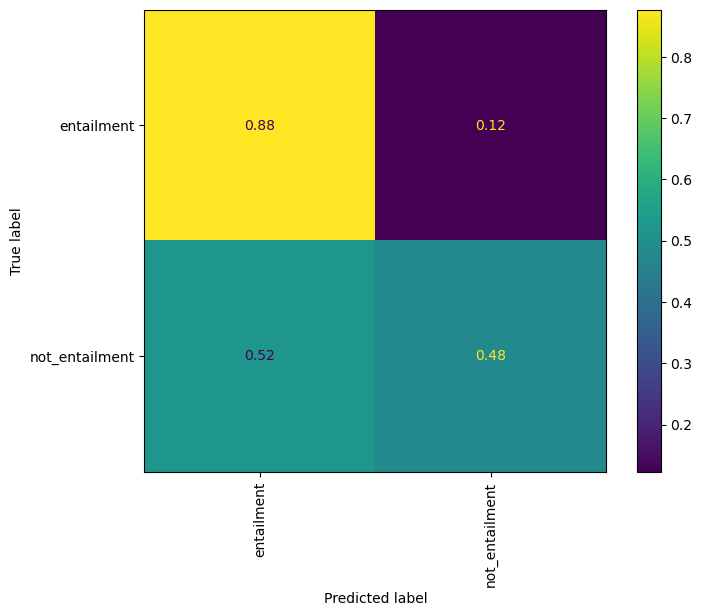

In [80]:
# Plot a confusion matrix to visualize the model's classification performance on the validation set.
# The matrix shows the true labels versus the predicted labels.
# The matrix is normalized by the number of true samples per class, making it easier to identify misclassifications.

fig, ax = plt.subplots(figsize=(8, 6))  # Initialize a plotting figure with a specified size.

# Generate and display the confusion matrix using true labels and predicted labels.
# The matrix is normalized, and custom display labels and x-axis tick rotation are applied for better visualization.
ConfusionMatrixDisplay.from_predictions(
    y_true=valid_labels,        # Actual labels from the validation set.
    y_pred=valid_preds,         # Predicted class labels by the model.
    ax=ax,                      # Plotting axis.
    normalize="true",           # Normalize by true class counts.
    display_labels=class_names, # Custom class names for display.
    xticks_rotation=90          # Rotate x-axis ticks for better readability.
)


In [81]:
# Log the confusion matrix to the Weights & Biases (Wandb) platform for monitoring and visualization.
# This allows for tracking the model's classification performance across different runs or iterations.

# log the Confusion Matrix to Wandb
wandb.log({
    "conf_mat": wandb.plot.confusion_matrix(
        preds=valid_preds,        # Model's predicted class labels.
        y_true=valid_labels,      # Actual labels from the validation set.
        class_names=class_names   # Custom class names for display in the confusion matrix.
    )
})



In [82]:
wandb.finish()


eval/accuracy,▁▄▆█████
eval/f1,▁▇▇█▇▇▇▇
eval/loss,█▇▅▃▂▁▂▂
eval/runtime,█▁▄▃▃▂▂▂
eval/samples_per_second,▁█▄▆▆▆▇▇
eval/steps_per_second,▁█▄▆▆▆▇▇
train/epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
train/global_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇███
train/learning_rate,█▇▆▄▃▂▁
train/loss,█▇▇▅▂▁▁
train/total_flos,▁


### <font color = 'indianred'> **Check the best saved model**</font>


In [83]:
# After training, let us check the best checkpoint
# We need this for Predictions and Evaluations
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")


The best model was saved at step 140.


## <font color = 'indianred'> **Test Set Predictions**


##  <font color = 'indianred'> **Pipeline for Predictions**

In [134]:
from transformers import Pipeline
import numpy as np

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

class SentencePairClassificationPipeline(Pipeline):
    def __call__(self, sentence1=None, sentence2=None, **kwargs):
        return super().__call__(inputs=(sentence1, sentence2), **kwargs)

    def _sanitize_parameters(self, **kwargs):
        return kwargs, {}, {}

    def preprocess(self, inputs=None): 
        sentence1, sentence2 = inputs       
        tokenized = self.tokenizer(sentence1, sentence2, return_tensors=self.framework, truncation=True, padding=True, max_length=512)
        return tokenized

    def _forward(self, model_inputs):
        model_inputs = {k: v.to(self.model.device) for k, v in model_inputs.items()}
        return self.model(**model_inputs)

    def postprocess(self, model_outputs):
        logits = model_outputs.logits[0].cpu().numpy()
        probabilities = softmax(logits)
        class_index = np.argmax(probabilities)
        label = self.model.config.id2label[class_index]
        score = probabilities[class_index]
        return {"label": label, "score": score}





In [133]:
premise = "A soccer game with multiple males playing."
hypothesis = "Some men are playing a sport."

with torch.no_grad():
    inputs = tokenizer(premise, hypothesis, return_tensors="pt", truncation=True, padding=True, max_length=512).to('cuda')
    outputs = model(**inputs)
    logits = outputs.logits[0].cpu().numpy()
    probabilities = softmax(logits)
    class_index = np.argmax(probabilities)
    label = model.config.id2label[class_index]
    score = probabilities[class_index]
    print({"label": label, "score": score})


{'label': 'entailment', 'score': 0.752499}


In [135]:
checkpoint = str(model_folder/'checkpoint-140')
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
model.to('cuda')
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

sentence_pair_pipeline = SentencePairClassificationPipeline(model=model, tokenizer=tokenizer)



##  <font color = 'indianred'> **Prediction for individual or small list of examples**

In [137]:
premise = "A soccer game with multiple males playing."
hypothesis = "Some men are playing a sport."

preds = sentence_pair_pipeline(sentence1=premise, sentence2=hypothesis)
preds

{'label': 'entailment', 'score': 0.752499}

In [131]:
preds = sentence_pair_pipeline(sentence1=premise, sentence2=hypothesis)
preds

{'label': 'not_entailment', 'score': 0.761552}

## <font color = 'indianred'> **Prediction for large dataset**

In [138]:
# Assuming you have a loaded dataset as `dataset`
predictions = []

for row in raw_datasets['test']:
    premise = row['sentence1']
    hypothesis = row['sentence2']
    pred = sentence_pair_pipeline(sentence1=premise, sentence2=hypothesis)
    predictions.append(pred)

# The predictions list will now contain the model's predictions for each sentence pair in the dataset


In [139]:
predictions

[{'label': 'not_entailment', 'score': 0.7923864},
 {'label': 'entailment', 'score': 0.8029449},
 {'label': 'not_entailment', 'score': 0.53974473},
 {'label': 'entailment', 'score': 0.66114044},
 {'label': 'not_entailment', 'score': 0.5494279},
 {'label': 'entailment', 'score': 0.75496966},
 {'label': 'not_entailment', 'score': 0.62987655},
 {'label': 'entailment', 'score': 0.6452959},
 {'label': 'entailment', 'score': 0.6877846},
 {'label': 'entailment', 'score': 0.7901002},
 {'label': 'entailment', 'score': 0.7319006},
 {'label': 'entailment', 'score': 0.79135174},
 {'label': 'entailment', 'score': 0.7460468},
 {'label': 'entailment', 'score': 0.66678375},
 {'label': 'entailment', 'score': 0.7305709},
 {'label': 'entailment', 'score': 0.7090598},
 {'label': 'not_entailment', 'score': 0.5361124},
 {'label': 'entailment', 'score': 0.78629917},
 {'label': 'not_entailment', 'score': 0.73278785},
 {'label': 'entailment', 'score': 0.7834552},
 {'label': 'entailment', 'score': 0.7919483},
 {